Library Import

In [1]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile,BasicAer
from qiskit.tools.jupyter import *
from qiskit.visualization import *
# from ibm_quantum_widgets import *
from qiskit_aer import AerSimulator
from qiskit.algorithms.optimizers import SPSA
import pandas as pd
from qiskit.circuit import ParameterVector
from qiskit.visualization import circuit_drawer


# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
# service = QiskitRuntimeService(channel="ibm_quantum")
from pylab import cm
from sklearn import metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.kernels import TrainableFidelityQuantumKernel
from qiskit_machine_learning.kernels.algorithms import QuantumKernelTrainer
from qiskit_machine_learning.algorithms import QSVC
# Invoke a primitive inside a session. For more details see https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials.html
# with Session(backend=service.backend("ibmq_qasm_simulator")):
#     result = Sampler().run(circuits).result()

In [2]:
class QKTCallback:
    """Callback wrapper class."""

    def __init__(self) -> None:
        self._data = [[] for i in range(5)]

    def callback(self, x0, x1=None, x2=None, x3=None, x4=None):
        """
        Args:
            x0: number of function evaluations
            x1: the parameters
            x2: the function value
            x3: the stepsize
            x4: whether the step was accepted
        """
        self._data[0].append(x0)
        self._data[1].append(x1)
        self._data[2].append(x2)
        self._data[3].append(x3)
        self._data[4].append(x4)

    def get_callback_data(self):
        return self._data

    def clear_callback_data(self):
        self._data = [[] for i in range(5)]

Preparing the Dataset

In [3]:
df = pd.read_csv(r'STANDARDIZED SAMPLE.csv')
ytrain= df.iloc[:,7]
Xtrain= df.iloc[:,1:7]
Xtrain

,Coolant temp,Fuel pressure,LOG(Engine rpm),LOG(Lub oil pressure),LOG(Coolant pressure),lub oil temp
0,-0.108643,-0.458618,-1.122023,-0.945244,2.504221,-1.053616
1,-0.270546,-0.467818,0.572158,0.821692,-0.386126,-0.342973
2,0.434519,0.943128,-0.368585,-0.357813,-0.804757,-0.731751
3,0.358127,-0.676976,0.087629,-9.286989,0.962594,1.208524
4,0.710329,-1.689018,-0.300498,0.580295,0.220930,0.659805
...,...,...,...,...,...,...
1195,0.002870,0.031966,0.555103,0.660490,1.108182,-0.584349
1196,0.898031,-1.843809,0.283783,0.509437,0.565864,0.733411
1197,0.308100,-0.268417,1.335523,0.440793,0.019946,-0.341390
1198,-0.430117,2.765807,-0.621706,0.292100,-0.100907,-0.596006


In [4]:
#To reduce training dataset size
Xtrain,Xtest , ytrain, ytest = train_test_split(Xtrain, ytrain,stratify=ytrain, test_size=0.25)

Define the Quantum Feature Map


Figure(454.719x535.111)
Trainable parameters: θ, ['θ[0]']


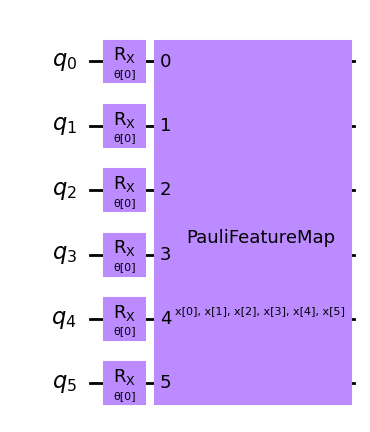

In [5]:
from qiskit.circuit.library import PauliFeatureMap
from qiskit.visualization import circuit_drawer

# Define the parameter vector
training_params = ParameterVector("θ", 1)

# Define the quantum circuit with PauliFeatureMap
fm0 = QuantumCircuit(6)
for i in range(6):
    fm0.rx(training_params[0], i)

# Define the PauliFeatureMap
fm1 = PauliFeatureMap(feature_dimension=6, reps=2)

# Create the feature map, composed of the two circuits
fm = fm0.compose(fm1)

# Print the circuit and trainable parameters
print(circuit_drawer(fm, output='mpl'))
print(f"Trainable parameters: {training_params}")
fm.draw(output="mpl")


In [6]:
print(fm.depth())

2


In [7]:
# Instantiate quantum kernel
quant_kernel = TrainableFidelityQuantumKernel(feature_map=fm, training_parameters=training_params)

# Set up the optimizer
cb_qkt = QKTCallback()
spsa_opt = SPSA(maxiter=10, callback=cb_qkt.callback, learning_rate=0.05, perturbation=0.05)

# Instantiate a quantum kernel trainer.
qkt = QuantumKernelTrainer(
    quantum_kernel=quant_kernel, loss="svc_loss", optimizer=spsa_opt, initial_point=[np.pi / 2]
)

In [ ]:
# Train the kernel using QKT directly
qka_results = qkt.fit(Xtrain, ytrain)
optimized_kernel = qka_results.quantum_kernel
print(qka_results)

Fit and Test the Model

In [ ]:
# Use QSVC for classification
qsvc = QSVC(quantum_kernel=optimized_kernel)

# Fit the QSVC
qsvc.fit(Xtrain, ytrain)

# Predict the labels
labels_test = qsvc.predict(Xtest)

# Evalaute the test accuracy
accuracy_test = metrics.balanced_accuracy_score(y_true=ytest, y_pred=labels_test)
print(f"accuracy test: {accuracy_test}")

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(ytest,labels_test))
print(classification_report(ytest,labels_test))

Visualize the Kernel Training Process

In [ ]:
plot_data = cb_qkt.get_callback_data()  # callback data
K = optimized_kernel.evaluate(Xtrain)  # kernel matrix evaluated on the training samples

plt.rcParams["font.size"] = 20
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].plot([i + 1 for i in range(len(plot_data[0]))], np.array(plot_data[2]), c="k", marker="o")
ax[0].set_xlabel("Iterations")
ax[0].set_ylabel("Loss")
ax[1].imshow(K, cmap=cm.get_cmap("bwr", 20))
fig.tight_layout()
plt.show()